## Download ET timeseries data from excel file

In [30]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import requests

# Load Excel file
df = pd.read_excel('field_locations.xlsx', sheet_name='Y_2024')

# API config
YOUR_API_KEY = 'mgv3HNfDIcsnIa4LKUYj2g8QXBNz09TyCOhFAw9JU0z149RrajkFwBVWwbZy'
header = {"Authorization": YOUR_API_KEY}

# List of models to request
# models = ["Ensemble", "SSEBop", "DisALEXI", "PTJPL", "geeSEBAL", "eeMETRIC", "SIMS"]
models = ["Ensemble"]

# Variables to request
# variables = ["ET", "ET_MAD_MIN", "ET_MAD_MAX", "ETo", "ETr", "ETof", "NDVI", "PR"]
variables = ["ET"] 

# Store all records in one list
all_records = []

# Loop over each row in the Excel
for idx, row in df.iterrows():
    id_number = str(row['ID'])
    farm = str(row['Farm'])
    section = str(row['Section'])
    year = int(row['Year'])
    latitude = float(row['Latitude'])
    longitude = float(row['Longitude'])

    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    for variable in variables:
        print(f"\n📍 Processing: ID={id_number} | Var={variable}")

        et_data = {}

        for model in models:
            args = {
                "date_range": [start_date, end_date],
                "interval": "daily",
                "geometry": [longitude, latitude],
                "model": model,
                "variable": variable,
                "reference_et": "gridMET",
                "units": "mm",
                "file_format": "JSON"
            }

            response = requests.post(
                headers=header,
                json=args,
                url="https://openet-api.org/raster/timeseries/point"
            )

            if response.status_code == 200:
                model_data = response.json()
                print(f"✅ {model} - {len(model_data)} records fetched.")
                et_data[model] = model_data
            else:
                print(f"❌ {model} - {response.status_code}: {response.text}")

        # Append full record
        all_records.append({
            "id_number": id_number,
            "farm": farm,
            "section": section,
            "year": year,
            "latitude": latitude,
            "longitude": longitude,
            "variable": variable,
            "et_data": et_data
        })

# Save everything to one JSON file
with open("example_openet_2024_test.json", "w") as f:
    json.dump(all_records, f, indent=2)

print("\n✅ All data saved to 'openet_all_variables_all_locations.json'")


📍 Processing: ID=1.0 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=2.0 | Var=ET
✅ Ensemble - 366 records fetched.

📍 Processing: ID=3.0 | Var=ET
✅ Ensemble - 366 records fetched.

✅ All data saved to 'openet_all_variables_all_locations.json'


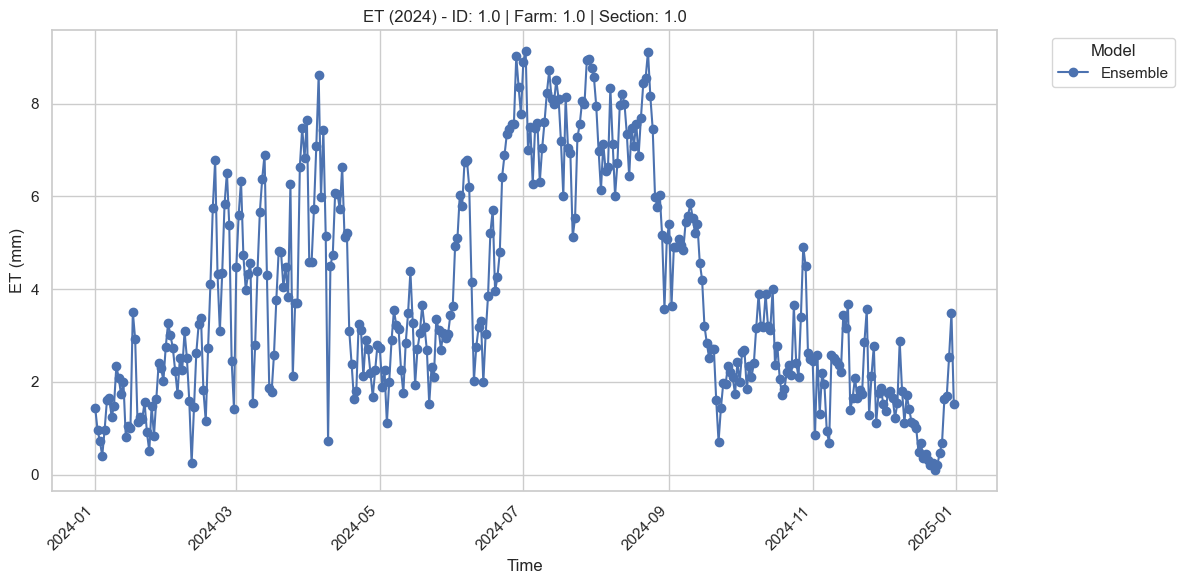

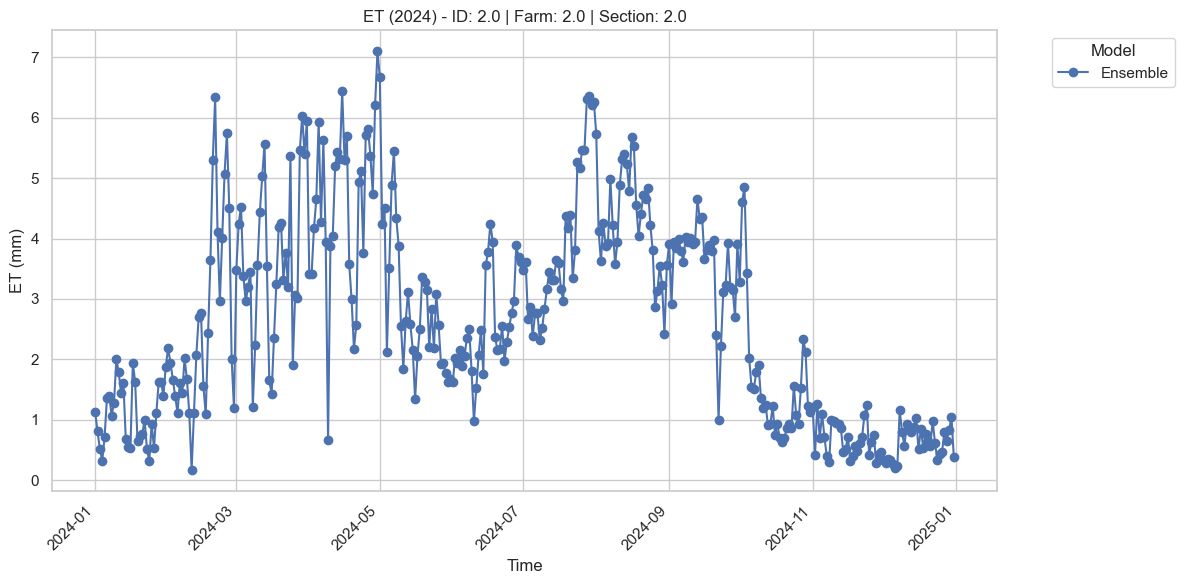

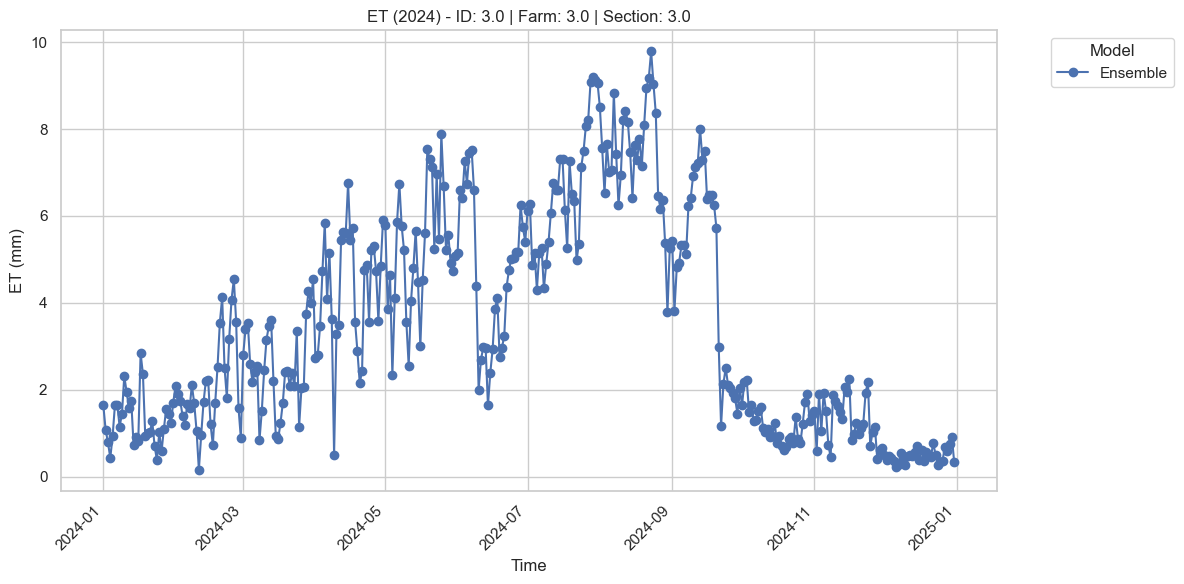

In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the combined JSON file
with open("example_openet_2024_test.json", "r") as f:
    all_data = json.load(f)

# Optional: prettier style
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 6)})

# Loop through each record (each location x variable)
for record in all_data:
    id_number = record['id_number']
    farm = record['farm']
    section = record['section']
    variable = record['variable']
    year = record['year']
    et_data = record['et_data']

    # Skip if no ET data
    if not et_data:
        continue

    # Build DataFrame from all models
    df_all = pd.DataFrame()

    for model, values in et_data.items():
        if not values:
            continue
        df_temp = pd.DataFrame(values)
        df_temp['time'] = pd.to_datetime(df_temp['time'])
        df_temp.set_index('time', inplace=True)
        df_temp = df_temp.rename(columns={'et': model})
        df_all = pd.concat([df_all, df_temp[model]], axis=1)

    if df_all.empty:
        continue

    df_all = df_all.sort_index()

    # Plot
    ax = df_all.plot(marker='o')
    plt.title(f"{variable} ({year}) - ID: {id_number} | Farm: {farm} | Section: {section}")
    plt.xlabel("Time")
    plt.ylabel(f"{variable} (mm)")
    plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [32]:
import json
import pandas as pd

# Load JSON file (list of records)
with open("example_openet_2024_test.json", "r") as f:
    data = json.load(f)

# Container for all rows
all_rows = []

# Loop through each record
for record in data:
    meta = {
        "id_number": str(record["id_number"]),
        "farm": str(record["farm"]),
        "section": str(record["section"]),
        "year": int(record["year"]),
        "latitude": float(record["latitude"]),
        "longitude": float(record["longitude"]),
        "variable": record["variable"]
    }

    # Build model-wise data frame
    et_frames = []
    for model, values in record["et_data"].items():
        if values:  # skip if empty
            df_model = pd.DataFrame(values)
            df_model["time"] = pd.to_datetime(df_model["time"])
            df_model.set_index("time", inplace=True)
            df_model.rename(columns={"et": model}, inplace=True)
            et_frames.append(df_model)

    if et_frames:
        df_merged = pd.concat(et_frames, axis=1).reset_index()
        for key, val in meta.items():
            df_merged[key] = val
        all_rows.append(df_merged)

# Combine all into one DataFrame
final_df = pd.concat(all_rows, ignore_index=True)

# Reorder columns
meta_cols = ["id_number", "farm", "section", "year", "latitude", "longitude", "variable", "time"]
model_cols = [col for col in final_df.columns if col not in meta_cols]
final_df = final_df[meta_cols + model_cols]

# Show result
# print(final_df.head())


In [33]:
final_df

,id_number,farm,section,year,latitude,longitude,variable,time,Ensemble
0,1.0,1.0,1.0,2024,34.43,-102.42,ET,2024-01-01,1.440
1,1.0,1.0,1.0,2024,34.43,-102.42,ET,2024-01-02,0.961
2,1.0,1.0,1.0,2024,34.43,-102.42,ET,2024-01-03,0.721
3,1.0,1.0,1.0,2024,34.43,-102.42,ET,2024-01-04,0.402
4,1.0,1.0,1.0,2024,34.43,-102.42,ET,2024-01-05,0.958
...,...,...,...,...,...,...,...,...,...
1093,3.0,3.0,3.0,2024,34.49,-102.47,ET,2024-12-27,0.686
1094,3.0,3.0,3.0,2024,34.49,-102.47,ET,2024-12-28,0.583
1095,3.0,3.0,3.0,2024,34.49,-102.47,ET,2024-12-29,0.751
1096,3.0,3.0,3.0,2024,34.49,-102.47,ET,2024-12-30,0.922


In [75]:
final_df.to_excel('ET_2024.xlsx')

## Download from multipolygons

In [34]:
import pandas as pd
import requests

# Step 1: Post the original request
API_KEY = 'mgv3HNfDIcsnIa4LKUYj2g8QXBNz09TyCOhFAw9JU0z149RrajkFwBVWwbZy'
headers = {"Authorization": API_KEY}

payload = {
    "asset_id": "projects/tony-1122/assets/TTU/test_et_aoi",
    "attributes": ["ID"],
    "date_range": ["2024-01-01", "2024-12-31"],
    "interval": "daily",
    "model": "Ensemble",
    "reducer": "mean",
    "reference_et": "gridMET",
    "units": "mm",
    "variable": "ET"
}

url = "https://openet-api.org/raster/timeseries/multipolygon"
response = requests.post(url, headers=headers, json=payload)

if response.status_code == 200:
    result = response.json()
    download_url = result.get("url")
    
    if download_url:
        print("📥 Fetching data from:", download_url)
        
        # Step 2: GET the data from the returned URL
        download_response = requests.get(download_url)
        if download_response.status_code == 200:
            # Load CSV into DataFrame
            from io import StringIO
            df = pd.read_csv(StringIO(download_response.text))
            print("✅ Data loaded successfully!")
            print(df.head())

            # Save to CSV
            df.to_csv("openet_ET_data_2024_test.csv", index=False)
            print("📁 Saved to 'openet_ET_data_2024.csv'")
        else:
            print("❌ Failed to download from returned URL")
            print(download_response.text)
    else:
        print("❌ 'url' not found in response")
else:
    print("❌ Initial request failed:", response.status_code)
    print(response.text)


📥 Fetching data from: https://earthengine-highvolume.googleapis.com/v1/projects/tony-1122/tables/fb9add6d64728d472c8427d7f5e56160-99205ab41da9c3d2db2d1dd40e2f8ca9:getFeatures
✅ Data loaded successfully!
         time   ID     et  hectares  megaliters
0  2024-01-01  1.0  1.504    95.359       1.434
1  2024-01-01  2.0  1.361    44.700       0.608
2  2024-01-01  3.0  1.527    31.234       0.477
3  2024-01-02  1.0  0.991    95.359       0.945
4  2024-01-02  2.0  0.928    44.700       0.415
📁 Saved to 'openet_ET_data_2024.csv'


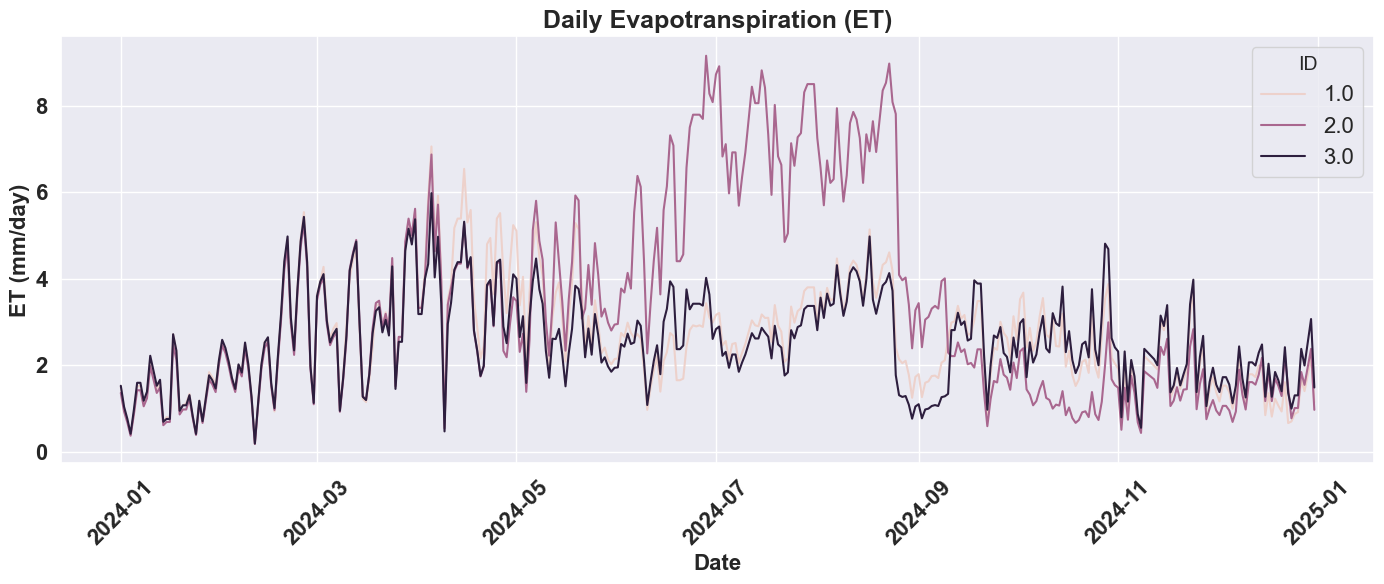

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the data
df = pd.read_csv("openet_ET_data_2024.csv")
df['time'] = pd.to_datetime(df['time'])

# Set seaborn style
sns.set_style("darkgrid")


plt.figure(figsize=(14, 6))

# Plot
sns.lineplot(data=df, x='time', y='et', hue='ID')

# Titles and labels with bold font
plt.title("Daily Evapotranspiration (ET)", fontsize=18, fontweight='bold')
plt.xlabel("Date", fontsize=16, fontweight='bold')
plt.ylabel("ET (mm/day)", fontsize=16, fontweight='bold')

# Tick styles
plt.xticks(rotation=45, fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

# Legend
plt.legend(title="ID", fontsize=16, title_fontsize=14)

# Layout
plt.tight_layout()
plt.show()


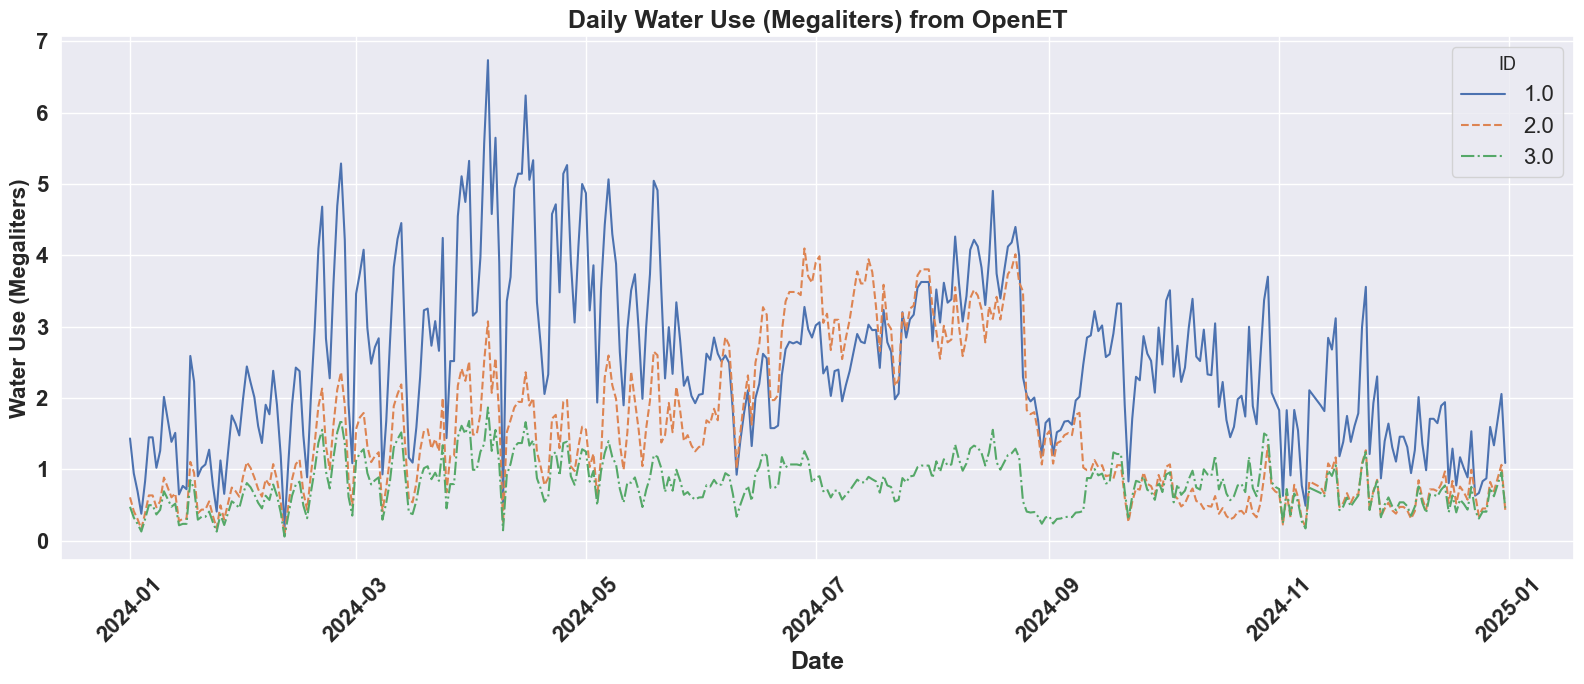

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the data
df = pd.read_csv("openet_ET_data_2024.csv")

# Convert 'time' to datetime
df['time'] = pd.to_datetime(df['time'])

# Clean the data
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df.dropna(subset=['megaliters'], inplace=True)

# Set seaborn style
sns.set_style("darkgrid")

# Prepare line styles
line_styles = ['-', '--', '-.', ':']
unique_ids = df['ID'].unique()
style_dict = {id_: line_styles[i % len(line_styles)] for i, id_ in enumerate(unique_ids)}

# Create the plot
plt.figure(figsize=(16, 7))
for id_ in unique_ids:
    subset = df[df['ID'] == id_]
    sns.lineplot(
        data=subset,
        x='time',
        y='megaliters',
        label=id_,
        linestyle=style_dict[id_]
    )

# Add titles and labels with larger bold font
plt.title("Daily Water Use (Megaliters) from OpenET", fontsize=18, fontweight='bold')
plt.xlabel("Date", fontsize=18, fontweight='bold')
plt.ylabel("Water Use (Megaliters)", fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.legend(title="ID", fontsize=16, title_fontsize=13)
plt.tight_layout()
plt.show()
